In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

#just to keep the upper limit included in the random number generation. 

In [4]:
mix = QuantumCircuit(1)
mix.rx(np.pi, 0)
mix.draw()

┌───────┐
q_0: ┤ Rx(π) ├
     └───────┘

In [5]:
miy = QuantumCircuit(1)
miy.ry(np.pi, 0)
miy.draw()

┌───────┐
q_0: ┤ Ry(π) ├
     └───────┘

In [6]:
miz = QuantumCircuit(1)
miz.rz(np.pi, 0)
miz.draw()

┌───────┐
q_0: ┤ Rz(π) ├
     └───────┘

In [7]:
mi = QuantumCircuit(1)
mi.rz(2*np.pi, 0)
mi.draw()

┌────────┐
q_0: ┤ Rz(2π) ├
     └────────┘

In [8]:
numLayer = 2
numQubit = 1
global iterations
global noisy

In [9]:
#Create unitaries here
unitary_param_1 = np.array([])
for i in range(0, 8):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

unitary_param_1 = [4.20362003, 5.93582256, 1.13444277, 0.80707608, 3.4027251, 0.82820306,
                   0.66563292, 4.04077958]

In [10]:
print(unitary_param_1)

[4.20362003, 5.93582256, 1.13444277, 0.80707608, 3.4027251, 0.82820306, 0.66563292, 4.04077958]


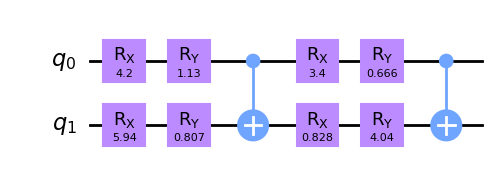

In [11]:
# First unitary
size = 2
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [12]:
def createProver(numQubit, numLayer):
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

In [13]:
def createEqSuperposQuaternionBSE():
    temp = QuantumCircuit(3)
    temp.h(0)
    temp.h(1)
    temp.h(2)
    return temp

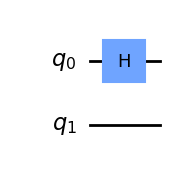

In [87]:
qcTest = QuantumCircuit(2)
qcTest.h(0)
qcTest.draw('mpl')

In [88]:
def createQuantumCircuit(state, numQubit, numLayer):
    circ = QuantumCircuit(5)
    #Create Quantum Circuit here
    
    superPosCircuit = createEqSuperposQuaternionBSE()
    circ.append(superPosCircuit, [0, 1, 2])

    circ.append(state, [3, 4])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [4])
    
    custom = miz.to_gate().control(2)
    circ.append(custom, [0, 3, 4])
    
    custom = miy.to_gate().control(2)
    circ.append(custom, [1, 3, 4])

    custom = mix.to_gate().control(2)
    circ.append(custom, [2, 3, 4])

    circ.x(0)
    custom = mi.to_gate().control(3)
    circ.append(custom, [0, 2, 3, 4])
    circ.x(0)
    
    circ.append(superPosCircuit.inverse(), [0, 1, 2])
    
    return circ

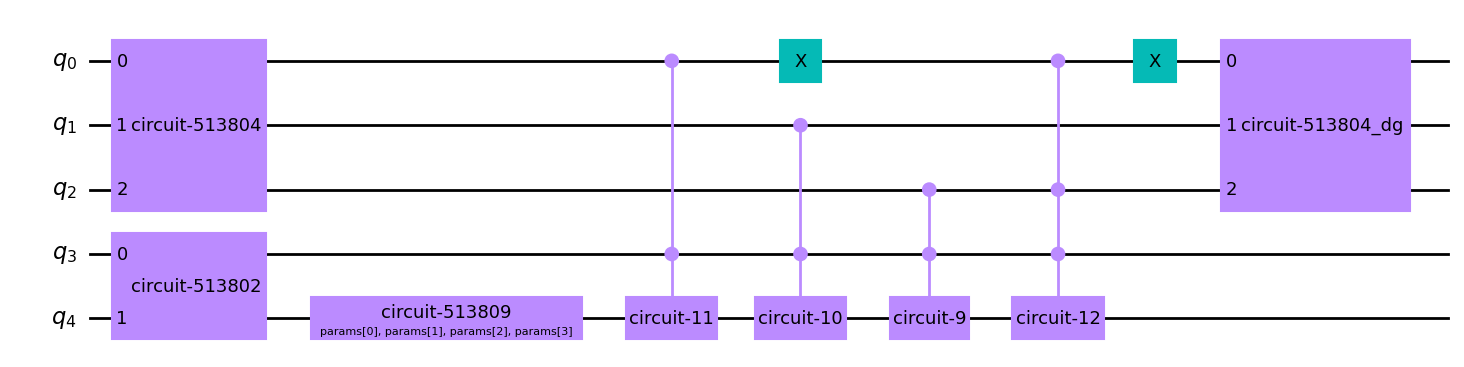

In [89]:
qCirc = createQuantumCircuit(qcTest, numQubit, numLayer)
qCirc.draw('mpl')

In [90]:
#use if noiseless
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [91]:
#Use if noisy
provider = IBMQ.get_provider(hub='ibm-q')
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_lima")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [92]:
#Create Hamiltonian here
hamiltonian = I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [93]:
def costf(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [94]:
def gradient(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [95]:
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3])])


In [96]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [97]:
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[5.77351582 0.71503032 4.36630877 3.97211599]
Initial Cost :  0.5


In [98]:
true_value = 0.5

In [99]:
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=100, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.5
Loss Value :  0.49999999999999983 1.0%
Loss Value :  0.49999999999999983 2.0%
Loss Value :  0.49999999999999994 3.0%
Loss Value :  0.4999999999999999 4.0%
Loss Value :  0.4999999999999999 5.0%
Loss Value :  0.4999999999999999 6.0%
Loss Value :  0.4999999999999999 7.0%
Loss Value :  0.5000000000000001 8.0%
Loss Value :  0.4999999999999999 9.0%
Loss Value :  0.49999999999999994 10.0%
Loss Value :  0.4999999999999999 11.0%
Loss Value :  0.49999999999999983 12.0%
Loss Value :  0.4999999999999999 13.0%
Loss Value :  0.5 14.0%
Loss Value :  0.4999999999999997 15.0%
Loss Value :  0.49999999999999983 16.0%
Loss Value :  0.49999999999999983 17.0%
Loss Value :  0.5 18.0%
Loss Value :  0.5000000000000002 19.0%
Loss Value :  0.4999999999999999 20.0%
Loss Value :  0.4999999999999999 21.0%
Loss Value :  0.49999999999999994 22.0%
Loss Value :  0.49999999999999967 23.0%
Loss Value :  0.49999999999999967 24.0%
Loss Value :  0.5 25.0%
Loss Value :  0.5000000000000002 26.0%
Loss Value

In [100]:
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=100, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.41562930402880666
Loss Value :  0.4244331871073281 1.0%
Loss Value :  0.41026576822223493 2.0%
Loss Value :  0.40713290512710854 3.0%
Loss Value :  0.42265729111743405 4.0%
Loss Value :  0.41352569347512064 5.0%
Loss Value :  0.427625168110794 6.0%
Loss Value :  0.4204061108041355 7.0%
Loss Value :  0.404917059622967 8.0%
Loss Value :  0.4132546139364989 9.0%
Loss Value :  0.4188557480985191 10.0%
Loss Value :  0.3979251212212385 11.0%
Loss Value :  0.41940240185906275 12.0%
Loss Value :  0.4003978027638712 13.0%
Loss Value :  0.41546361314827307 14.0%
Loss Value :  0.425782950299369 15.0%
Loss Value :  0.40229047885703695 16.0%
Loss Value :  0.4185394058126512 17.0%
Loss Value :  0.4125590654976764 18.0%
Loss Value :  0.4089455066735391 19.0%
Loss Value :  0.4160453350122186 20.0%
Loss Value :  0.41749788557957696 21.0%
Loss Value :  0.41075056555660744 22.0%
Loss Value :  0.39404008186656053 23.0%
Loss Value :  0.4062433255759425 24.0%
Loss Value :  0.41995817900512

In [101]:
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.49999999999999994


In [102]:
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  0.5
Noiseless :  0.5000000000000001
Noisy :  0.4000534346511256
Noise Resilient Value :  0.49999999999999994


In [103]:
def writeToFile():
    file = open("Q8_GBSE.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [104]:
writeToFile()